# Store Sales Forecasting

## Evaluation Metric

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

In [1]:
# Basic imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

## Data

This dataset has several csv files. It looks like most of them can be joined to the training data via one column or another

1. Holidays_events -> Can join on Date. There is some tricky moved variable I might need to write a function for.
2. Oil -> Oil price for the day. Can join on the date (Prices for both train and test are included).
3. Stores -> Store info. Can join on store number
4. Transactions -> Can join on Date+StoreNbr

In [2]:
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')
df_oil = pd.read_csv('./Data/oil.csv')
df_stores = pd.read_csv('./Data/stores.csv')
df_transactions = pd.read_csv('./Data/transactions.csv')
df_holidays = pd.read_csv('./Data/holidays_events.csv')

# Store originals just in case
df_train0 = df_train.copy()
df_test0 = df_test.copy()
df_oil0 = df_oil.copy()
df_stores0 = df_stores.copy()
df_transactions0 = df_transactions.copy()
df_holidays0 = df_holidays.copy()

## Data exploration

In [3]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [6]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
# Check for nulls, NaNs, duplicates
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [8]:
# Oil is the only dataframe that has nulls. We'll want to impute the values. (Would probably make sense to average out the day before and after for price)
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [9]:
# Check for duplicates
print('Duplicates Training: ', df_train.duplicated().sum())
print('Duplicates Oil: ', df_oil.duplicated().sum())
print('Duplicates Transactions: ', df_transactions.duplicated().sum())
print('Duplicates Stores: ', df_stores.duplicated().sum())
print('Duplicates Holidays: ', df_holidays.duplicated().sum())

Duplicates Training:  0
Duplicates Oil:  0
Duplicates Transactions:  0
Duplicates Stores:  0
Duplicates Holidays:  0


## Data Preprocessing

### Imputing values in oil

In [10]:
# Impute the values for the oil dataframe

# Function to calculate median of adjacent rows
def median_of_adjacent(row_index, df):
    if row_index == 0:
        # If it's the first row, take the median with the next row
        return np.median([df.loc[row_index, 'dcoilwtico'], df.loc[row_index + 1, 'dcoilwtico']])
    elif row_index == len(df) - 1:
        # If it's the last row, take the median with the previous row
        return np.median([df.loc[row_index, 'dcoilwtico'], df.loc[row_index - 1, 'dcoilwtico']])
    else:
        # Otherwise, take the median of the previous and next rows
        return np.median([df.loc[row_index - 1, 'dcoilwtico'], df.loc[row_index + 1, 'dcoilwtico']])

# Find indices of missing values
missing_indices = df_oil[df_oil['dcoilwtico'].isna()].index

# Fill missing values
for idx in missing_indices:
    df_oil.at[idx, 'dcoilwtico'] = median_of_adjacent(idx, df_oil)

## Joining the dataframes

In [11]:
def join_all_to_df(df0):
    df = df0.copy()
    # Join oil
    df = pd.merge(df, df_oil, on='date', how='left')
    # Join stores
    df = pd.merge(df, df_stores, on='store_nbr', how='left')
    # Join transactions
    df = pd.merge(df, df_transactions, left_on=['date','store_nbr'], right_on=['date','store_nbr'], how='left')

    # Join holidays
    # Ignore for now

    return df

In [12]:
df_train = join_all_to_df(df_train)

In [13]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN


## Observations

Looks like there is 1218 unique dates in oil, and 1600 in train. This leads to about 28% of the merged data being na. Something to keep an eye on.

Transactions has some missing too, about 8%. I also see some rows with no transactions and the sales are 0. Maybe these are holidays?

In [14]:
# Looks like there is 1218 unique dates in oil, and 1600 in train. This leads to about 28% of the merged data being na. Something to keep an eye on.
# Trnasactions has some missing too, about 8%
df_train.date.describe()
df_oil.date.describe()
df_transactions.date.describe()

count          83488
unique          1682
top       2017-08-15
freq              54
Name: date, dtype: object

In [15]:
# Looks like there is 1218 unique dates in oil, and 1600 in train. This leads to about 28% of the merged data being na. Something to keep an eye on.
# Trnasactions has some missing too, about 8%
df_train.isna().sum()

print('Oil price missing', 862488*100 / df_train.shape[0])
print('Transactions missing', 245784*100 / df_train.shape[0])

Oil price missing 28.741092636579573
Transactions missing 8.190375648807953


<Axes: xlabel='date'>

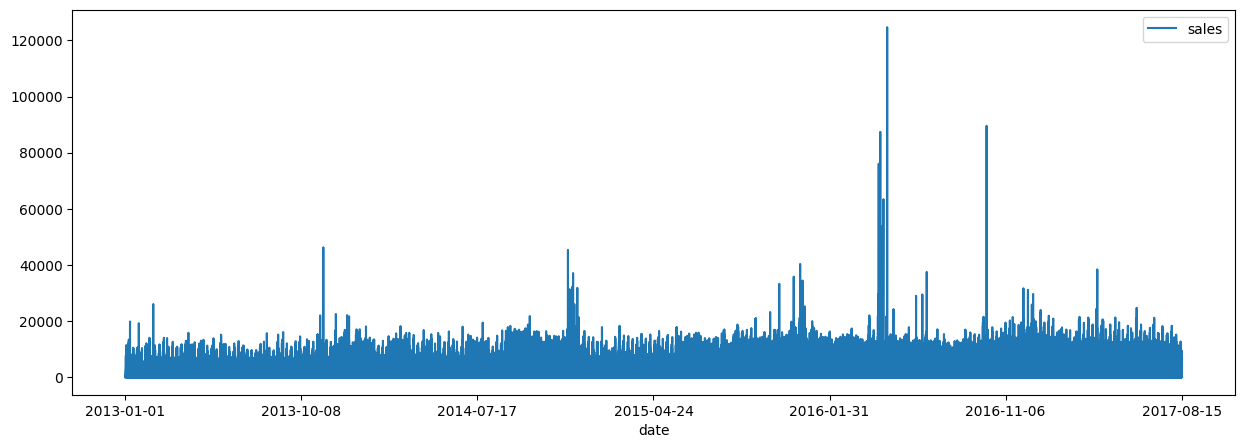

In [16]:
df_train.plot(x='date', y='sales', figsize=(15,5))

# Data preprocessing

In [17]:
def create_features(df0):
    df = df0.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['day'] = df.date.dt.day
    df.drop('date', axis=1, inplace=True)
    return df

In [18]:
df_train = create_features(df_train)

In [19]:
df_train.head()

,id,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,transactions,dayofweek,dayofyear,quarter,month,year,day
0,0,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1,1,1,1,2013,1
1,1,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1,1,1,1,2013,1
2,2,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1,1,1,1,2013,1
3,3,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1,1,1,1,2013,1
4,4,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,NaN,1,1,1,1,2013,1


In [20]:
# get dummies and drop id
df_train.drop('id', axis=1, inplace=True)
df_train = pd.get_dummies(df_train)

# Create a model

In [21]:
# Split the data. Lets pick a date to split on, and we want year as a feature so we'll split at 2016
train_set = df_train.loc[df_train['year'] < 2016]
test_set = df_train.loc[df_train['year'] >= 2016]

In [22]:
import xgboost as xgb

# Set up a regressor
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.05, early_stopping_rounds=50, random_state=42)

# This regressor for using the squared log error produced results where all the predictions were between 1 and 2. Poor results. 
# xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror'n_estimators=500, learning_rate = 0.01, early_stopping_rounds=25, random_state=42)

y_train = train_set['sales']
y_test = test_set['sales']
X_train = train_set.drop('sales', axis=1)
X_test = test_set.drop('sales', axis=1)


In [23]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

#import pickle
#path = './'

#with open(path+'xgb_reg_model.pickle', 'rb') as to_read:
#    xgb_reg = pickle.load(to_read)

[0]	validation_0-rmse:1284.89346
[50]	validation_0-rmse:613.45752
[100]	validation_0-rmse:552.24264
[150]	validation_0-rmse:543.01944
[200]	validation_0-rmse:538.53770
[250]	validation_0-rmse:540.45598
[259]	validation_0-rmse:540.38720


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
# save the model
#import pickle

#path = './'

#with open(path+'xgb_reg_model.pickle', 'wb') as to_write:
#    pickle.dump(xgb_reg, to_write)

# Evaluate the model

In [25]:
y_preds = xgb_reg.predict(X_test)

train_set_final = X_train
train_set_final['sales'] = y_train

test_set_final = X_test
test_set_final['sales_pred'] = y_preds
test_set_final['sales_actual'] = y_test

### Evaluation Metric

It looks like we have negative predictions, which won't work with mean squared log error. In this case, it doesn't make sense to have negative sales anyways. There might be something wrong with our model.

In [26]:
print(test_set_final.loc[test_set_final['sales_pred'] < 0].shape)
print(test_set_final.shape)

(116264, 89)
(1054944, 89)


Only a small percentage of our values are negative. In this case, I'm going to set them all to 0. With those at 0 we can evaluate our model.

In [27]:
test_set_final['sales_pred'] = test_set_final['sales_pred'].clip(lower=0)

print(test_set_final.loc[test_set_final['sales_pred'] < 0].shape)

(0, 89)


In [28]:
from sklearn.metrics import mean_squared_log_error

rmsle = np.sqrt(mean_squared_log_error(test_set_final['sales_actual'], test_set_final[['sales_pred']]))

print('Root mean squared log error:', rmsle)

Root mean squared log error: 1.5465569597670812


In [29]:
## Add back the date column

def add_date(df0):
    df = df0.copy()
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    return df

train_set_final = add_date(train_set_final)
test_set_final = add_date(test_set_final)

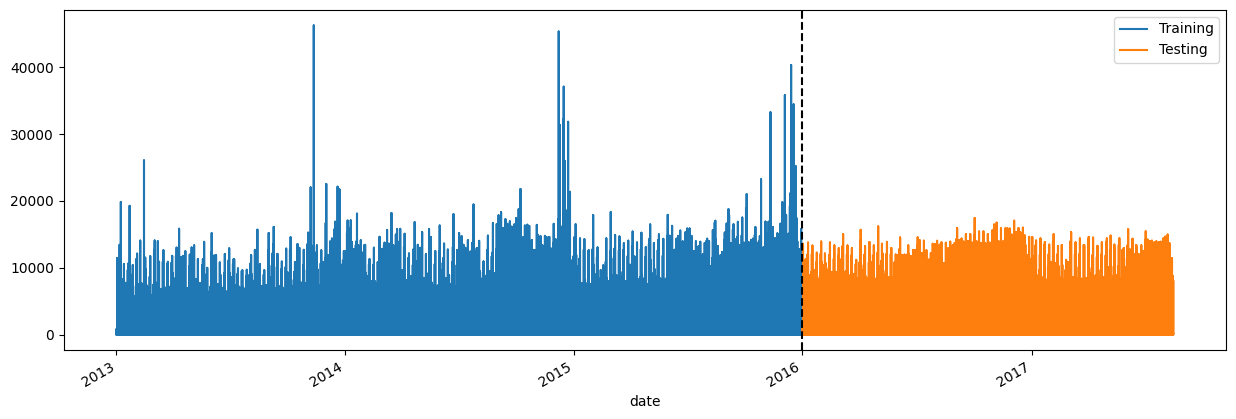

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
train_set_final.plot(ax=ax, x='date', y='sales',label='Training Set')
test_set_final.plot(ax=ax, x='date', y='sales_pred',label='Testing Set Prediction')
ax.axvline('2016-01-01', color='black', linestyle='--')
ax.legend(['Training','Testing'])
plt.show()

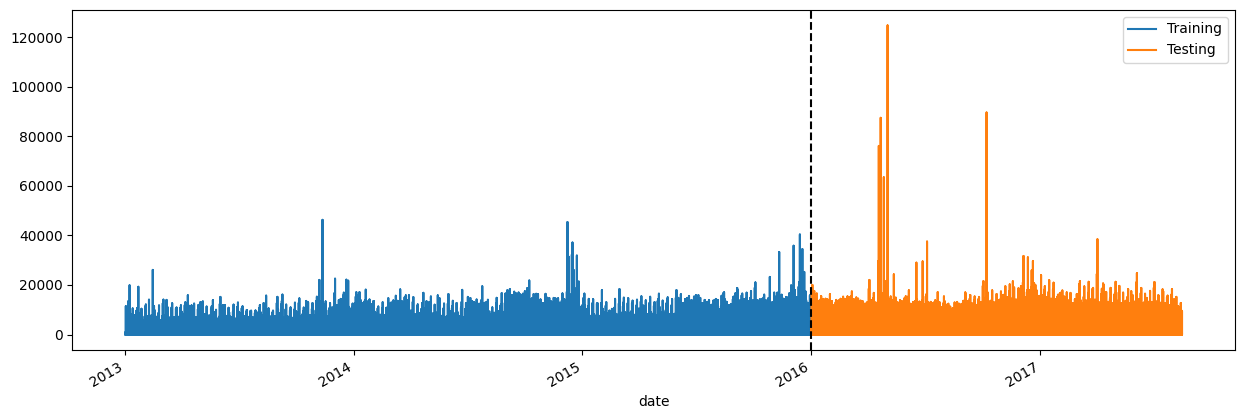

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
train_set_final.plot(ax=ax, x='date', y='sales',label='Training Set')
test_set_final.plot(ax=ax, x='date', y='sales_actual',label='Testing Set Actual')
ax.axvline('2016-01-01', color='black', linestyle='--')
ax.legend(['Training','Testing'])
plt.show()

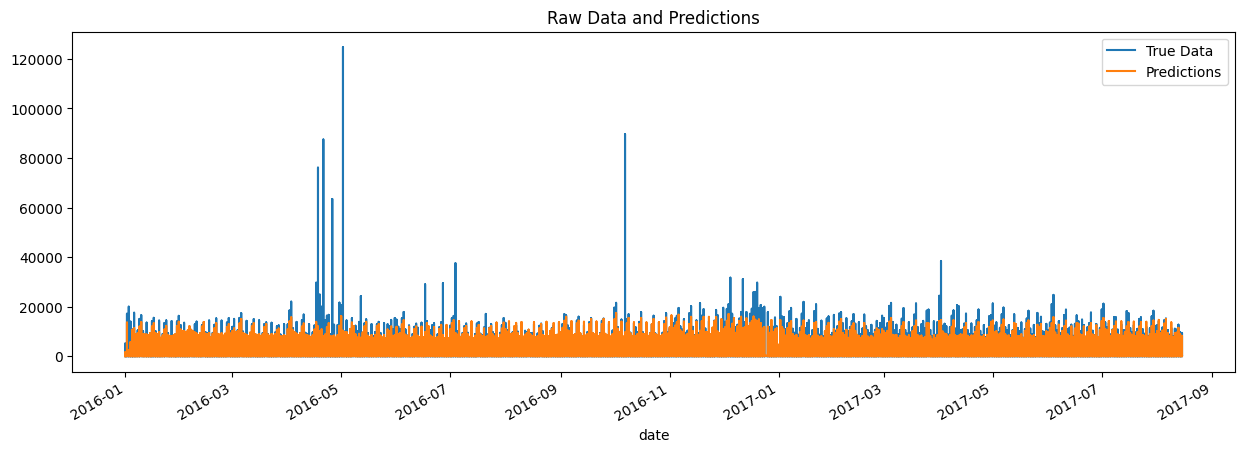

In [32]:
ax = test_set_final.plot(x='date', y='sales_actual', figsize=(15,5))
test_set_final.plot(ax=ax, x='date', y='sales_pred')
ax.set_title('Raw Data and Predictions')
plt.legend(['True Data', 'Predictions'])
plt.show()

## Observations

There were a small set of negative predictions we had to handle, but otherwise the predictions seem at least reasonable. Enough for a submission.

In [33]:
# Create a model for submission.
df_test = join_all_to_df(df_test)
df_test = create_features(df_test)

# get dummies and drop id
df_test.drop('id', axis=1, inplace=True)
df_test = pd.get_dummies(df_test)

df_test_preds = xgb_reg.predict(df_test)

In [40]:
df_test_preds = df_test_preds.clip(min=0)

In [41]:
df_submission = pd.DataFrame({'id': range(3000888, 3029400), 'sales' : df_test_preds})

In [44]:
df_submission.to_csv('submission_1.csv', index=False)

In [45]:
df_submission.head()

,id,sales
0,3000888,0.000000
1,3000889,0.000000
2,3000890,374.784180
3,3000891,887.136292
4,3000892,0.000000
